<a href="https://colab.research.google.com/github/Andy025824/Marketing-Campaign/blob/main/marketing_campaign_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marketing Campaign Analysis - Phase-End Project

## Project Overview
This notebook performs comprehensive exploratory data analysis and hypothesis testing on marketing campaign data to understand factors contributing to customer acquisition based on the 4 Ps of marketing: Product, Price, Place, and Promotion.

**Dataset**: Marketing campaign data with 2,240 customers and 28 variables
**Objective**: Gain insights into customer behavior and test marketing hypotheses

## 1. Import Libraries and Load Data

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

# Load Data
df = pd.read_csv('/tmp/marketing_data.csv')
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (2240, 28)

Column Names:
['ID', 'Year_Birth', 'Education', 'Marital_Status', ' Income ', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response', 'Complain', 'Country']

First 5 rows:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Investigation and Quality Check

In [29]:
# Investigate data types and missing values
print("Data Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# Check specific variables mentioned in requirements
print("\nDt_Customer sample values:")
print(df['Dt_Customer'].head())

print("\nIncome sample values (note the formatting):")
print(df[' Income '].head())

# Check categorical variables
print("\nEducation categories:")
print(df['Education'].value_counts())

print("\nMarital Status categories:")
print(df['Marital_Status'].value_counts())

Data Types:
ID                      int64
Year_Birth              int64
Education              object
Marital_Status         object
 Income                object
Kidhome                 int64
Teenhome                int64
Dt_Customer            object
Recency                 int64
MntWines                int64
MntFruits               int64
MntMeatProducts         int64
MntFishProducts         int64
MntSweetProducts        int64
MntGoldProds            int64
NumDealsPurchases       int64
NumWebPurchases         int64
NumCatalogPurchases     int64
NumStorePurchases       int64
NumWebVisitsMonth       int64
AcceptedCmp3            int64
AcceptedCmp4            int64
AcceptedCmp5            int64
AcceptedCmp1            int64
AcceptedCmp2            int64
Response                int64
Complain                int64
Country                object
dtype: object

Missing Values:
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
 Income      

## 3. Data Cleaning and Preprocessing

In [30]:
# Clean Income column - remove $ and commas, convert to numeric
df['Income_Clean'] = df[' Income '].str.replace('$', '').str.replace(',', '').str.strip()
df['Income_Clean'] = pd.to_numeric(df['Income_Clean'], errors='coerce')

# Clean Dt_Customer - convert to datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# Clean Marital Status - consolidate unusual categories
print("Marital Status before cleaning:")
print(df['Marital_Status'].value_counts())

df['Marital_Status_Clean'] = df['Marital_Status'].replace({
    'YOLO': 'Single',
    'Alone': 'Single',
    'Absurd': 'Single'
})

print("\nMarital Status after cleaning:")
print(df['Marital_Status_Clean'].value_counts())

print("\nIncome cleaning results:")
print(f"Missing values before: {df[' Income '].isnull().sum()}")
print(f"Missing values after: {df['Income_Clean'].isnull().sum()}")
print(f"Income range: ${df['Income_Clean'].min():,.0f} - ${df['Income_Clean'].max():,.0f}")

Marital Status before cleaning:
Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: count, dtype: int64

Marital Status after cleaning:
Marital_Status_Clean
Married     864
Together    580
Single      487
Divorced    232
Widow        77
Name: count, dtype: int64

Income cleaning results:
Missing values before: 24
Missing values after: 24
Income range: $1,730 - $666,666


## 4. Missing Value Imputation

In [31]:
# Impute missing income values based on Education and Marital Status
# Calculate mean income by groups
income_means = df.groupby(['Education', 'Marital_Status_Clean'])['Income_Clean'].mean()
print("Mean income by Education and Marital Status:")
print(income_means.round(0))

# Function to fill missing income values
def fill_income(row):
    if pd.isna(row['Income_Clean']):
        try:
            return income_means.loc[row['Education'], row['Marital_Status_Clean']]
        except KeyError:
            # If combination doesn't exist, use overall mean
            return df['Income_Clean'].mean()
    return row['Income_Clean']

df['Income_Imputed'] = df.apply(fill_income, axis=1)

print(f"\nMissing values after imputation: {df['Income_Imputed'].isnull().sum()}")
print(f"Imputed income range: ${df['Income_Imputed'].min():,.0f} - ${df['Income_Imputed'].max():,.0f}")

Mean income by Education and Marital Status:
Education   Marital_Status_Clean
2n Cycle    Divorced                49395.0
            Married                 46201.0
            Single                  53674.0
            Together                44736.0
            Widow                   51392.0
Basic       Divorced                 9548.0
            Married                 21960.0
            Single                  18239.0
            Together                21240.0
            Widow                   22123.0
Graduation  Divorced                54526.0
            Married                 50800.0
            Single                  51366.0
            Together                55758.0
            Widow                   54977.0
Master      Divorced                50332.0
            Married                 53286.0
            Single                  53787.0
            Together                52109.0
            Widow                   58402.0
PhD         Divorced                53097.

## 5. Feature Engineering - Create New Variables

In [32]:
# Create new variables as specified in requirements

# 1. Total number of children
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

# 2. Age (assuming current year is 2014 based on latest Dt_Customer)
current_year = 2014
df['Age'] = current_year - df['Year_Birth']

# 3. Total spending across all product categories
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts',
                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['Total_Spending'] = df[spending_columns].sum(axis=1)

# 4. Total purchases across all channels (as hinted in requirements)
purchase_columns = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Purchases'] = df[purchase_columns].sum(axis=1)

# Display summary of new variables
print("New Variables Summary:")
print(f"Total_Children - Range: {df['Total_Children'].min()}-{df['Total_Children'].max()}, Mean: {df['Total_Children'].mean():.2f}")
print(f"Age - Range: {df['Age'].min()}-{df['Age'].max()}, Mean: {df['Age'].mean():.1f}")
print(f"Total_Spending - Range: ${df['Total_Spending'].min()}-${df['Total_Spending'].max()}, Mean: ${df['Total_Spending'].mean():.0f}")
print(f"Total_Purchases - Range: {df['Total_Purchases'].min()}-{df['Total_Purchases'].max()}, Mean: {df['Total_Purchases'].mean():.1f}")

New Variables Summary:
Total_Children - Range: 0-3, Mean: 0.95
Age - Range: 18-121, Mean: 45.2
Total_Spending - Range: $5-$2525, Mean: $606
Total_Purchases - Range: 0-32, Mean: 12.5


## 6. Exploratory Data Analysis - Box Plots and Histograms

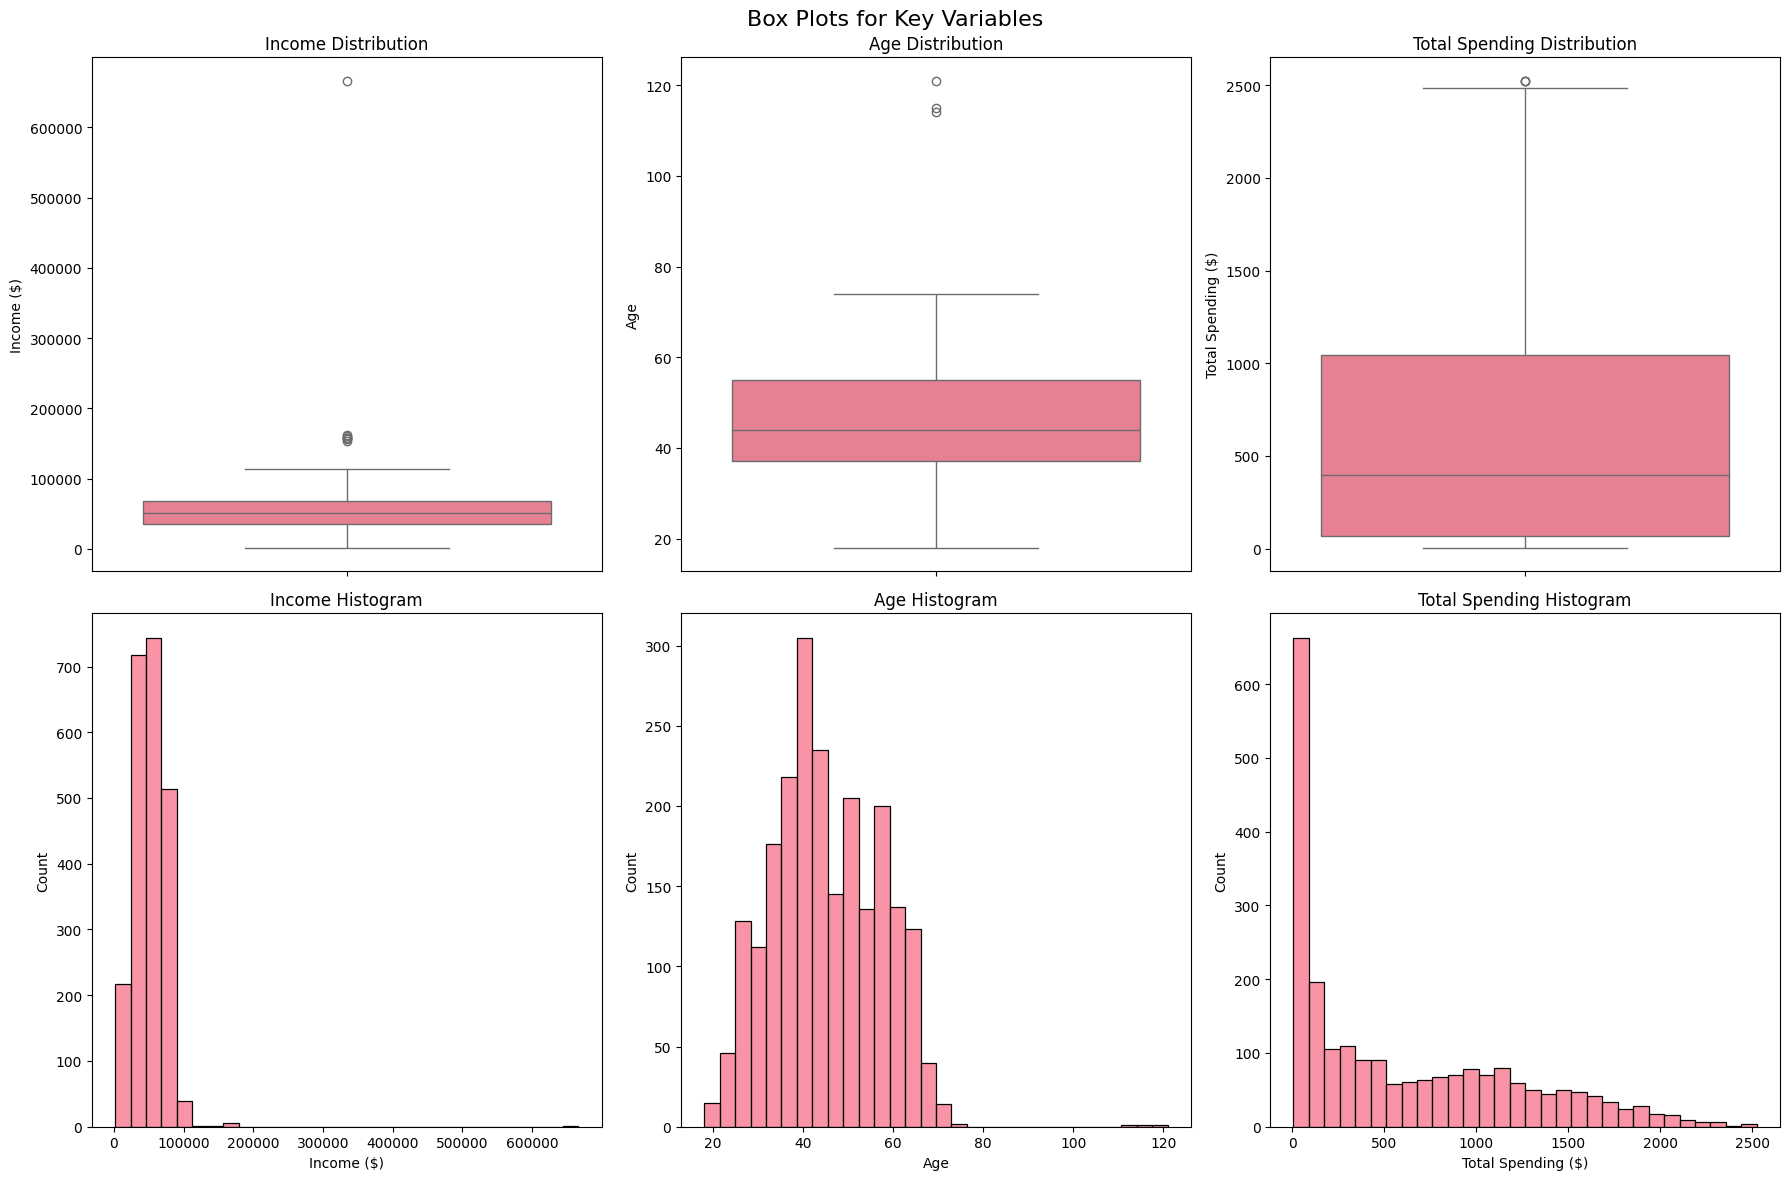

In [33]:
# Create box plots for key numerical variables
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Box Plots for Key Variables', fontsize=16)

# Box plots
sns.boxplot(y=df['Income_Imputed'], ax=axes[0,0])
axes[0,0].set_title('Income Distribution')
axes[0,0].set_ylabel('Income ($)')

sns.boxplot(y=df['Age'], ax=axes[0,1])
axes[0,1].set_title('Age Distribution')
axes[0,1].set_ylabel('Age')

sns.boxplot(y=df['Total_Spending'], ax=axes[0,2])
axes[0,2].set_title('Total Spending Distribution')
axes[0,2].set_ylabel('Total Spending ($)')

# Histograms
sns.histplot(df['Income_Imputed'], bins=30, ax=axes[1,0])
axes[1,0].set_title('Income Histogram')
axes[1,0].set_xlabel('Income ($)')

sns.histplot(df['Age'], bins=30, ax=axes[1,1])
axes[1,1].set_title('Age Histogram')
axes[1,1].set_xlabel('Age')

sns.histplot(df['Total_Spending'], bins=30, ax=axes[1,2])
axes[1,2].set_title('Total Spending Histogram')
axes[1,2].set_xlabel('Total Spending ($)')

plt.tight_layout()
plt.show()

## 7. Outlier Detection and Treatment

In [34]:
# Outlier detection using IQR method
def identify_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for outliers in key variables
outlier_columns = ['Income_Imputed', 'Age', 'Total_Spending', 'Total_Purchases']
print("Outlier Analysis:")

for col in outlier_columns:
    outliers, lower, upper = identify_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")
    print(f"  Bounds: {lower:.0f} - {upper:.0f}")

# Treatment: Cap extreme values at 99th and 1st percentiles
for col in outlier_columns:
    p99 = df[col].quantile(0.99)
    p1 = df[col].quantile(0.01)
    df[col + '_treated'] = df[col].clip(lower=p1, upper=p99)

print("\nOutlier treatment completed - values capped at 1st and 99th percentiles")

Outlier Analysis:
Income_Imputed: 8 outliers (0.36%)
  Bounds: -13588 - 117416
Age: 3 outliers (0.13%)
  Bounds: 10 - 82
Total_Spending: 3 outliers (0.13%)
  Bounds: -1396 - 2511
Total_Purchases: 0 outliers (0.00%)
  Bounds: -12 - 36

Outlier treatment completed - values capped at 1st and 99th percentiles


## 8. Encoding Categorical Variables

In [35]:
# Ordinal encoding for Education (assuming hierarchical order)
education_order = ['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']
df['Education_Ordinal'] = df['Education'].map({edu: i for i, edu in enumerate(education_order)})

print("Education Ordinal Mapping:")
for i, edu in enumerate(education_order):
    print(f"  {edu}: {i}")

# One-hot encoding for Marital Status and Country
marital_dummies = pd.get_dummies(df['Marital_Status_Clean'], prefix='Marital')
country_dummies = pd.get_dummies(df['Country'], prefix='Country')

# Combine with main dataframe
df_encoded = pd.concat([df, marital_dummies, country_dummies], axis=1)

print(f"\nOne-hot encoding completed:")
print(f"Marital Status columns: {marital_dummies.columns.tolist()}")
print(f"Country columns: {country_dummies.columns.tolist()}")
print(f"Final dataset shape: {df_encoded.shape}")

Education Ordinal Mapping:
  Basic: 0
  2n Cycle: 1
  Graduation: 2
  Master: 3
  PhD: 4

One-hot encoding completed:
Marital Status columns: ['Marital_Divorced', 'Marital_Married', 'Marital_Single', 'Marital_Together', 'Marital_Widow']
Country columns: ['Country_AUS', 'Country_CA', 'Country_GER', 'Country_IND', 'Country_ME', 'Country_SA', 'Country_SP', 'Country_US']
Final dataset shape: (2240, 53)


## 9. Correlation Analysis - Heatmap

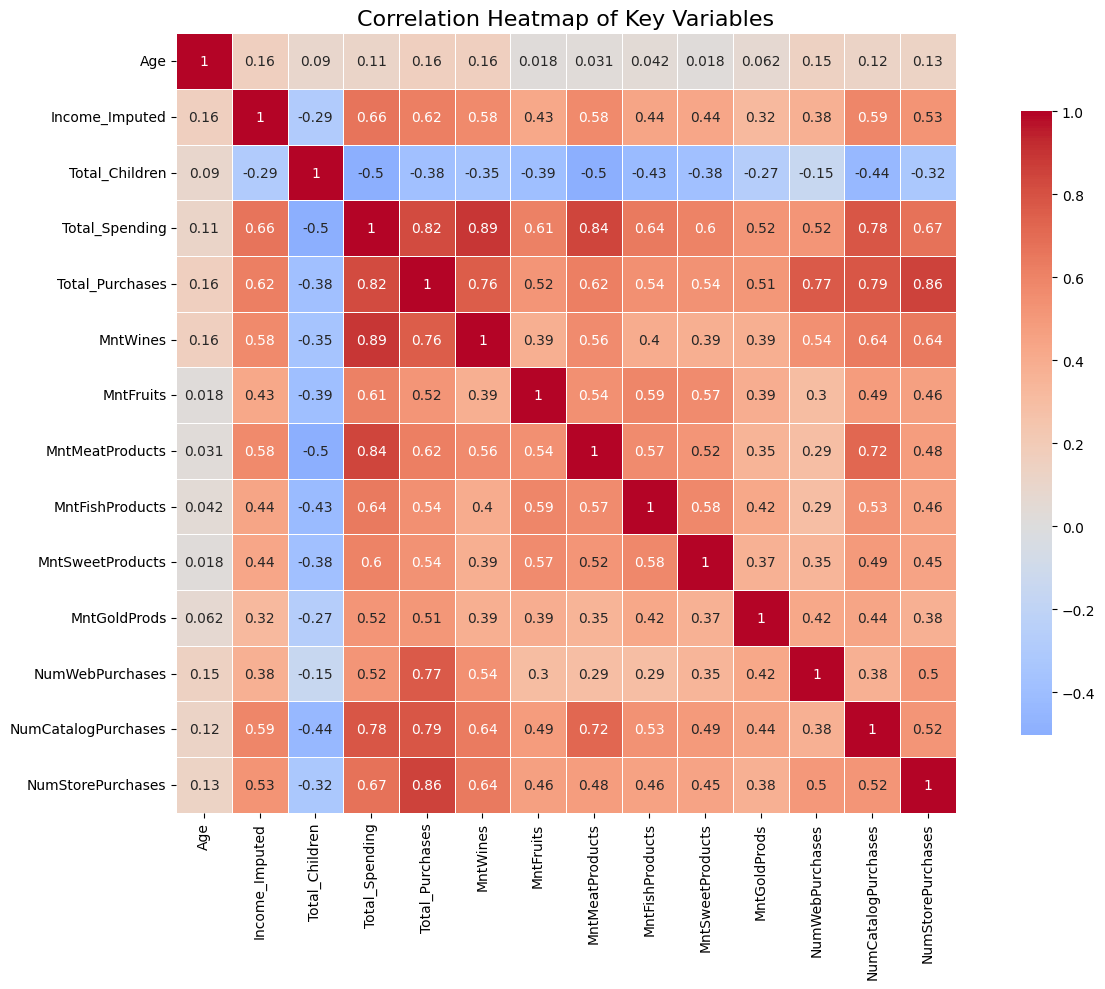

Strongest Positive Correlations (>0.5):
  Total_Spending - MntWines: 0.892
  Total_Purchases - NumStorePurchases: 0.855
  Total_Spending - MntMeatProducts: 0.843
  Total_Spending - Total_Purchases: 0.821
  Total_Purchases - NumCatalogPurchases: 0.786
  Total_Spending - NumCatalogPurchases: 0.779
  Total_Purchases - NumWebPurchases: 0.766
  Total_Purchases - MntWines: 0.756
  MntMeatProducts - NumCatalogPurchases: 0.724
  Total_Spending - NumStorePurchases: 0.675


In [36]:
# Select numerical variables for correlation analysis
correlation_vars = ['Age', 'Income_Imputed', 'Total_Children', 'Total_Spending', 'Total_Purchases',
                   'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                   'MntSweetProducts', 'MntGoldProds', 'NumWebPurchases',
                   'NumCatalogPurchases', 'NumStorePurchases']

correlation_matrix = df_encoded[correlation_vars].corr()

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Key Variables', fontsize=16)
plt.tight_layout()
plt.show()

# Print strongest correlations
print("Strongest Positive Correlations (>0.5):")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for var1, var2, corr in corr_pairs[:10]:
    print(f"  {var1} - {var2}: {corr:.3f}")

## 10. Hypothesis Testing

In [37]:
print("=== HYPOTHESIS TESTING ===")

# Create age groups for analysis
df_encoded['Age_Group'] = pd.cut(df_encoded['Age'], bins=[0, 40, 60, 100],
                                labels=['Young', 'Middle', 'Old'])

# Hypothesis 1: Older people prefer shopping in-store
print("\n1. Hypothesis: Older people are not as tech-savvy and prefer shopping in-store")
age_channel_analysis = df_encoded.groupby('Age_Group')[['NumStorePurchases', 'NumWebPurchases', 'NumCatalogPurchases']].mean()
print("Average purchases by channel and age group:")
print(age_channel_analysis.round(2))

# Statistical test
young_old = df_encoded[df_encoded['Age_Group'].isin(['Young', 'Old'])]
young_store = young_old[young_old['Age_Group'] == 'Young']['NumStorePurchases']
old_store = young_old[young_old['Age_Group'] == 'Old']['NumStorePurchases']
t_stat1, p_val1 = ttest_ind(old_store, young_store)
print(f"Statistical Test (Old vs Young store purchases): t={t_stat1:.3f}, p={p_val1:.3f}")
print(f"Result: {'SUPPORTED' if p_val1 < 0.05 and t_stat1 > 0 else 'NOT SUPPORTED'}")

=== HYPOTHESIS TESTING ===

1. Hypothesis: Older people are not as tech-savvy and prefer shopping in-store
Average purchases by channel and age group:
           NumStorePurchases  NumWebPurchases  NumCatalogPurchases
Age_Group                                                         
Young                   5.38             3.65                 2.32
Middle                  5.92             4.29                 2.74
Old                     6.57             4.62                 3.42
Statistical Test (Old vs Young store purchases): t=5.181, p=0.000
Result: SUPPORTED


In [38]:
# Hypothesis 2: Customers with kids prefer shopping online
print("\n2. Hypothesis: Customers with kids have less time to visit stores and prefer online")
customers_with_kids = df_encoded[df_encoded['Total_Children'] > 0]
customers_without_kids = df_encoded[df_encoded['Total_Children'] == 0]

kids_stats = {
    'With Kids': {
        'Online': customers_with_kids['NumWebPurchases'].mean(),
        'Store': customers_with_kids['NumStorePurchases'].mean(),
        'Count': len(customers_with_kids)
    },
    'Without Kids': {
        'Online': customers_without_kids['NumWebPurchases'].mean(),
        'Store': customers_without_kids['NumStorePurchases'].mean(),
        'Count': len(customers_without_kids)
    }
}

for group, stats in kids_stats.items():
    print(f"{group} (n={stats['Count']}): Online={stats['Online']:.2f}, Store={stats['Store']:.2f}")

t_stat2, p_val2 = ttest_ind(customers_with_kids['NumWebPurchases'], customers_without_kids['NumWebPurchases'])
print(f"Statistical Test (Web purchases with vs without kids): t={t_stat2:.3f}, p={p_val2:.3f}")
print(f"Result: {'SUPPORTED' if p_val2 < 0.05 and t_stat2 > 0 else 'NOT SUPPORTED'}")


2. Hypothesis: Customers with kids have less time to visit stores and prefer online
With Kids (n=1602): Online=3.96, Store=5.20
Without Kids (n=638): Online=4.39, Store=7.26
Statistical Test (Web purchases with vs without kids): t=-3.324, p=0.001
Result: NOT SUPPORTED


In [39]:
# Hypothesis 3: Other distribution channels cannibalize store sales
print("\n3. Hypothesis: Other distribution channels may cannibalize sales at the store")
corr_web_store = df_encoded['NumWebPurchases'].corr(df_encoded['NumStorePurchases'])
corr_catalog_store = df_encoded['NumCatalogPurchases'].corr(df_encoded['NumStorePurchases'])

print(f"Correlation between channels:")
print(f"  Web - Store: {corr_web_store:.3f}")
print(f"  Catalog - Store: {corr_catalog_store:.3f}")

if corr_web_store < -0.1 or corr_catalog_store < -0.1:
    print("Result: EVIDENCE OF CANNIBALIZATION (negative correlation)")
else:
    print("Result: NO EVIDENCE OF CANNIBALIZATION (positive/neutral correlation suggests complementary channels)")


3. Hypothesis: Other distribution channels may cannibalize sales at the store
Correlation between channels:
  Web - Store: 0.503
  Catalog - Store: 0.519
Result: NO EVIDENCE OF CANNIBALIZATION (positive/neutral correlation suggests complementary channels)


In [40]:
# Hypothesis 4: US vs Rest of World performance
print("\n4. Hypothesis: Does the US fare significantly better than the rest of the world in total purchases?")
us_customers = df_encoded[df_encoded['Country'] == 'US']['Total_Purchases']
non_us_customers = df_encoded[df_encoded['Country'] != 'US']['Total_Purchases']

us_stats = {
    'US': {'mean': us_customers.mean(), 'count': len(us_customers)},
    'Non-US': {'mean': non_us_customers.mean(), 'count': len(non_us_customers)}
}

for region, stats in us_stats.items():
    print(f"{region} (n={stats['count']}): Average total purchases = {stats['mean']:.2f}")

t_stat4, p_val4 = ttest_ind(us_customers, non_us_customers)
print(f"Statistical Test (US vs Non-US): t={t_stat4:.3f}, p={p_val4:.3f}")
print(f"Result: {'US PERFORMS BETTER' if p_val4 < 0.05 and t_stat4 > 0 else 'NO SIGNIFICANT DIFFERENCE'}")


4. Hypothesis: Does the US fare significantly better than the rest of the world in total purchases?
US (n=109): Average total purchases = 13.51
Non-US (n=2131): Average total purchases = 12.49
Statistical Test (US vs Non-US): t=1.451, p=0.147
Result: NO SIGNIFICANT DIFFERENCE


## 11. Analysis Questions - Visualizations and Insights

=== ANALYSIS QUESTIONS ===

1. Product Performance by Revenue


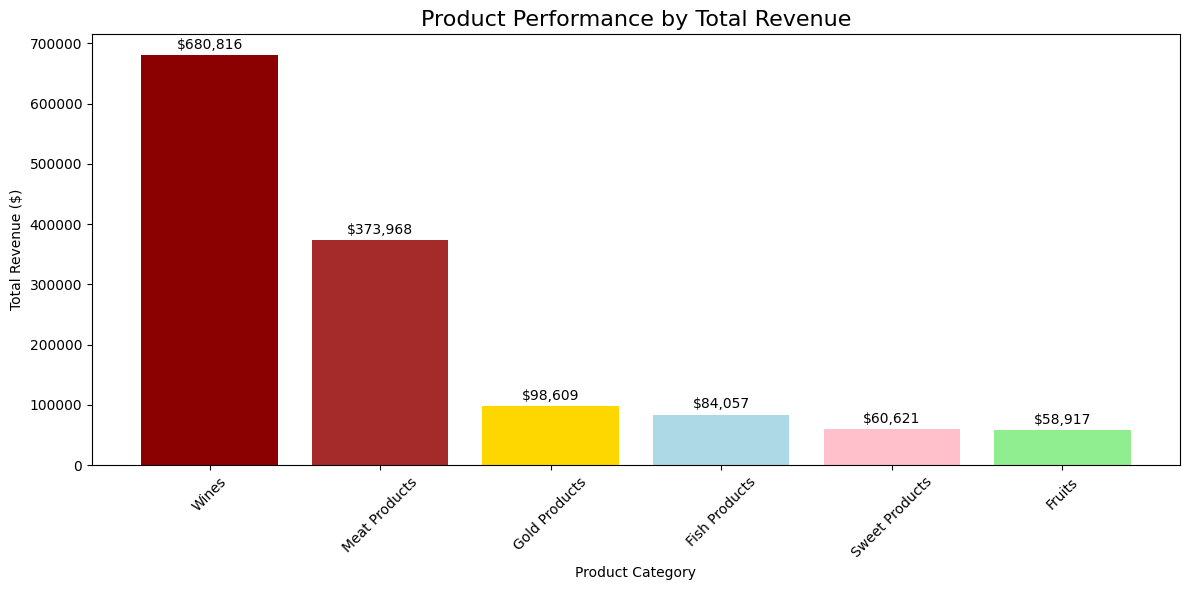

Product Revenue Ranking:
1. Wines: $680,816 (50.2% of total revenue)
2. Meat Products: $373,968 (27.6% of total revenue)
3. Gold Products: $98,609 (7.3% of total revenue)
4. Fish Products: $84,057 (6.2% of total revenue)
5. Sweet Products: $60,621 (4.5% of total revenue)
6. Fruits: $58,917 (4.3% of total revenue)


In [41]:
# Question 1: Which products are performing best/worst in terms of revenue?
print("=== ANALYSIS QUESTIONS ===")
print("\n1. Product Performance by Revenue")

product_revenue = {
    'Wines': df_encoded['MntWines'].sum(),
    'Meat Products': df_encoded['MntMeatProducts'].sum(),
    'Gold Products': df_encoded['MntGoldProds'].sum(),
    'Fish Products': df_encoded['MntFishProducts'].sum(),
    'Sweet Products': df_encoded['MntSweetProducts'].sum(),
    'Fruits': df_encoded['MntFruits'].sum()
}

# Create bar plot for product revenue
plt.figure(figsize=(12, 6))
products = list(product_revenue.keys())
revenues = list(product_revenue.values())

bars = plt.bar(products, revenues, color=['darkred', 'brown', 'gold', 'lightblue', 'pink', 'lightgreen'])
plt.title('Product Performance by Total Revenue', fontsize=16)
plt.ylabel('Total Revenue ($)')
plt.xlabel('Product Category')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, revenue in zip(bars, revenues):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
             f'${revenue:,.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print ranking
product_ranking = sorted(product_revenue.items(), key=lambda x: x[1], reverse=True)
print("Product Revenue Ranking:")
for i, (product, revenue) in enumerate(product_ranking, 1):
    percentage = (revenue / sum(product_revenue.values())) * 100
    print(f"{i}. {product}: ${revenue:,} ({percentage:.1f}% of total revenue)")


2. Age vs Last Campaign Acceptance Rate
           Acceptance_Rate  Total_Customers  Total_Accepted
Age_Group                                                  
Young                 15.5              847             131
Middle                14.2             1124             160
Old                   16.2              266              43


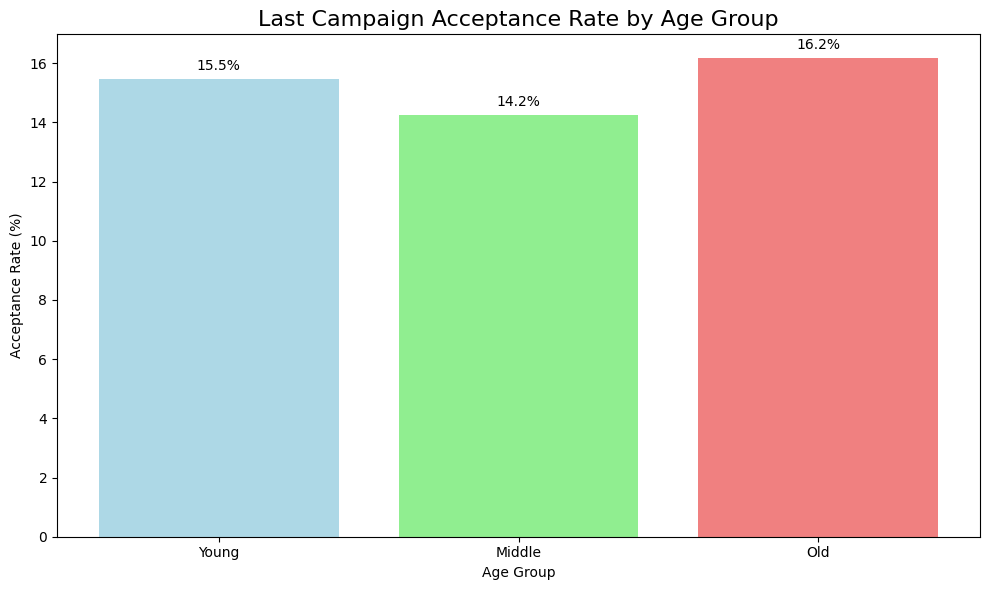

In [42]:
# Question 2: Pattern between age and last campaign acceptance
print("\n2. Age vs Last Campaign Acceptance Rate")
age_campaign = df_encoded.groupby('Age_Group')['Response'].agg(['mean', 'count', 'sum'])
age_campaign.columns = ['Acceptance_Rate', 'Total_Customers', 'Total_Accepted']
age_campaign['Acceptance_Rate'] = age_campaign['Acceptance_Rate'] * 100  # Convert to percentage

print(age_campaign.round(1))

# Visualize age vs campaign acceptance
plt.figure(figsize=(10, 6))
age_groups = age_campaign.index
acceptance_rates = age_campaign['Acceptance_Rate']

bars = plt.bar(age_groups, acceptance_rates, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Last Campaign Acceptance Rate by Age Group', fontsize=16)
plt.ylabel('Acceptance Rate (%)')
plt.xlabel('Age Group')

# Add value labels
for bar, rate in zip(bars, acceptance_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{rate:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


3. Countries with Most Last Campaign Acceptances
Top 5 countries by campaign acceptance:
Country
SP     176
SA      52
CA      38
AUS     23
GER     17
Name: count, dtype: int64

Country Statistics (sorted by total acceptances):
         Total_Customers  Accepted  Acceptance_Rate
Country                                            
SP                  1095       176             16.1
SA                   337        52             15.4
CA                   268        38             14.2
AUS                  160        23             14.4
GER                  120        17             14.2
IND                  148        13              8.8
US                   109        13             11.9
ME                     3         2             66.7


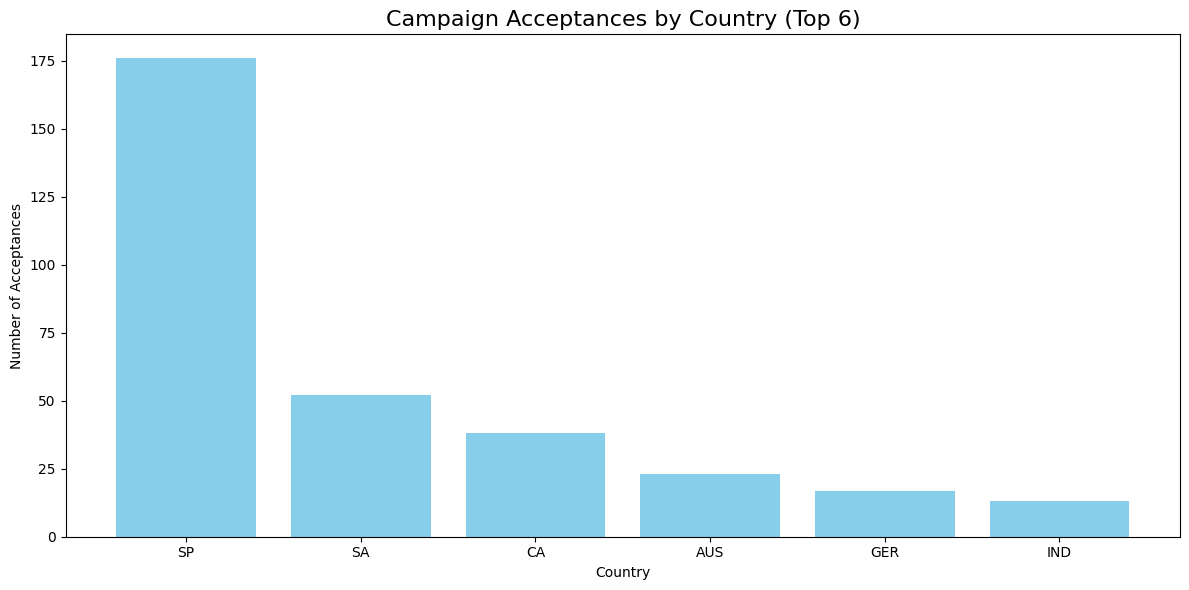

In [43]:
# Question 3: Country with greatest number of customers who accepted last campaign
print("\n3. Countries with Most Last Campaign Acceptances")
country_acceptance = df_encoded[df_encoded['Response'] == 1]['Country'].value_counts()
print("Top 5 countries by campaign acceptance:")
print(country_acceptance.head())

# Calculate acceptance rates by country
country_stats = df_encoded.groupby('Country')['Response'].agg(['count', 'sum', 'mean'])
country_stats.columns = ['Total_Customers', 'Accepted', 'Acceptance_Rate']
country_stats['Acceptance_Rate'] = country_stats['Acceptance_Rate'] * 100
country_stats = country_stats.sort_values('Accepted', ascending=False)

print("\nCountry Statistics (sorted by total acceptances):")
print(country_stats.round(1))

# Visualize
plt.figure(figsize=(12, 6))
top_countries = country_stats.head(6)
plt.bar(top_countries.index, top_countries['Accepted'], color='skyblue')
plt.title('Campaign Acceptances by Country (Top 6)', fontsize=16)
plt.ylabel('Number of Acceptances')
plt.xlabel('Country')
plt.tight_layout()
plt.show()


4. Number of Children vs Total Spending
                Mean_Spending  Median_Spending  Count  Std_Spending
Total_Children                                                     
0                     1106.03           1189.5    638        645.00
1                      472.73            305.0   1128        478.00
2                      245.95             93.0    421        311.33
3                      274.60             88.0     53        414.28


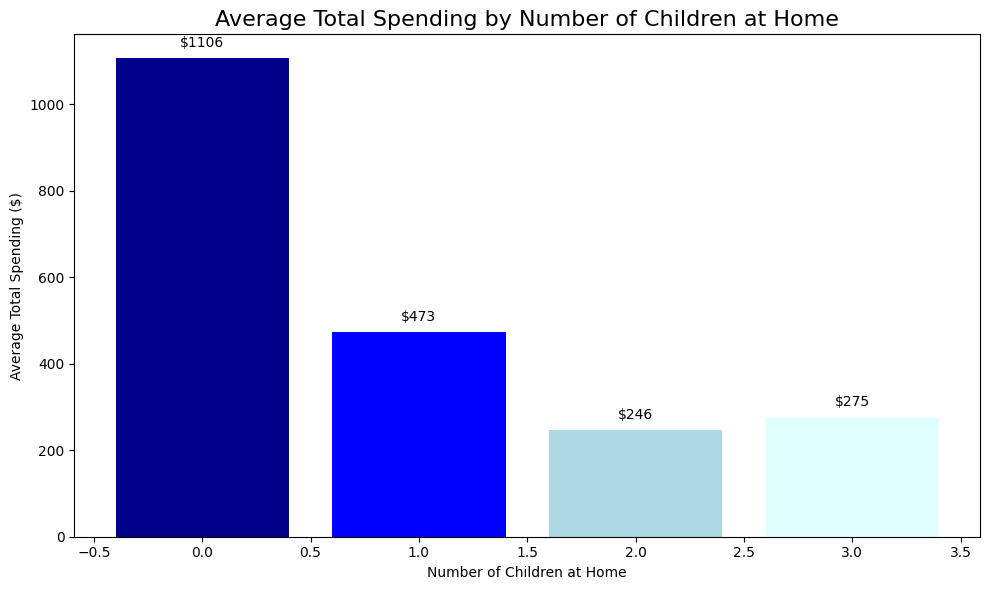


Statistical Test (No kids vs With kids): t=29.127, p=0.000
Difference is SIGNIFICANT


In [44]:
# Question 4: Pattern between number of children and total spend
print("\n4. Number of Children vs Total Spending")
children_spending = df_encoded.groupby('Total_Children')['Total_Spending'].agg(['mean', 'median', 'count', 'std'])
children_spending.columns = ['Mean_Spending', 'Median_Spending', 'Count', 'Std_Spending']
print(children_spending.round(2))

# Visualize
plt.figure(figsize=(10, 6))
children_counts = children_spending.index
mean_spending = children_spending['Mean_Spending']

bars = plt.bar(children_counts, mean_spending, color=['darkblue', 'blue', 'lightblue', 'lightcyan'])
plt.title('Average Total Spending by Number of Children at Home', fontsize=16)
plt.ylabel('Average Total Spending ($)')
plt.xlabel('Number of Children at Home')

# Add value labels
for bar, spending in zip(bars, mean_spending):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             f'${spending:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Statistical significance test
no_kids = df_encoded[df_encoded['Total_Children'] == 0]['Total_Spending']
with_kids = df_encoded[df_encoded['Total_Children'] > 0]['Total_Spending']
t_stat, p_val = ttest_ind(no_kids, with_kids)
print(f"\nStatistical Test (No kids vs With kids): t={t_stat:.3f}, p={p_val:.3f}")
print(f"Difference is {'SIGNIFICANT' if p_val < 0.05 else 'NOT SIGNIFICANT'}")


5. Education Background of Customers Who Complained
Total customers who complained in last 2 years: 21

Complainers by Education Level:
  Graduation: 14 (66.7%)
  2n Cycle: 4 (19.0%)
  Master: 2 (9.5%)
  PhD: 1 (4.8%)

Comparison with Overall Population:
            Overall_Population_%  Complainers_%
Education                                      
2n Cycle                     9.1           19.0
Basic                        2.4            0.0
Graduation                  50.3           66.7
Master                      16.5            9.5
PhD                         21.7            4.8


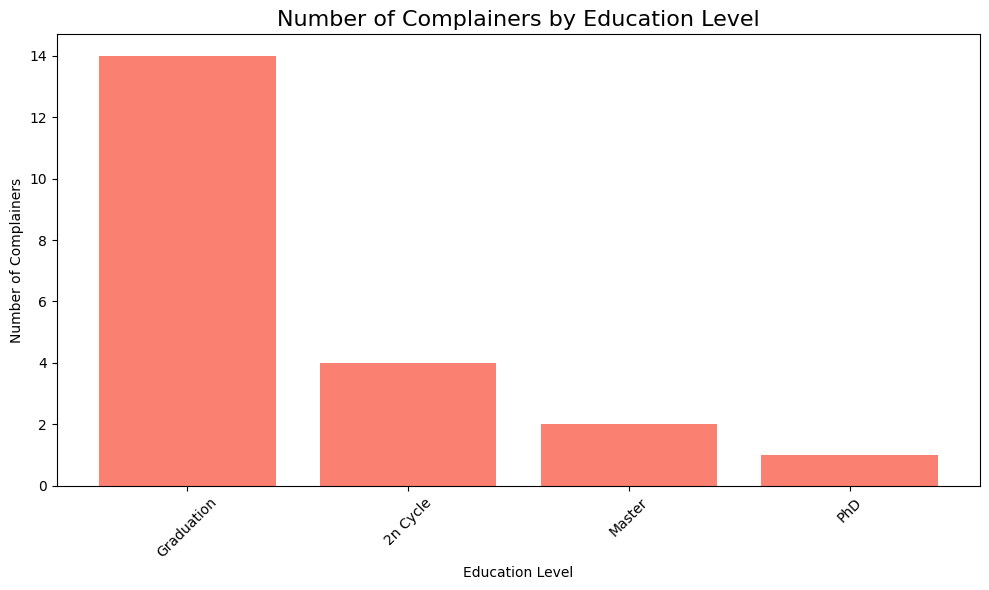

In [45]:
# Question 5: Education background of customers who complained
print("\n5. Education Background of Customers Who Complained")
complainers = df_encoded[df_encoded['Complain'] == 1]
complainer_education = complainers['Education'].value_counts()
total_complainers = len(complainers)

print(f"Total customers who complained in last 2 years: {total_complainers}")
print("\nComplainers by Education Level:")
for education, count in complainer_education.items():
    percentage = (count / total_complainers) * 100
    print(f"  {education}: {count} ({percentage:.1f}%)")

# Compare with overall education distribution
print("\nComparison with Overall Population:")
overall_education = df_encoded['Education'].value_counts(normalize=True) * 100
complainer_education_pct = complainer_education / total_complainers * 100

comparison_df = pd.DataFrame({
    'Overall_Population_%': overall_education,
    'Complainers_%': complainer_education_pct
}).fillna(0)

print(comparison_df.round(1))

# Visualize
plt.figure(figsize=(10, 6))
education_levels = complainer_education.index
counts = complainer_education.values

plt.bar(education_levels, counts, color='salmon')
plt.title('Number of Complainers by Education Level', fontsize=16)
plt.ylabel('Number of Complainers')
plt.xlabel('Education Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 12. Summary and Key Insights

In [46]:
print("=== PROJECT SUMMARY AND KEY INSIGHTS ===")

print("\n DATASET OVERVIEW:")
print(f"  • Total customers analyzed: {len(df_encoded):,}")
print(f"  • Variables after processing: {df_encoded.shape[1]}")
print(f"  • Missing values imputed: {df[' Income '].isnull().sum()}")
print(f"  • Outliers treated: {sum([len(identify_outliers_iqr(df, col)[0]) for col in outlier_columns])}")

print("\n HYPOTHESIS TESTING RESULTS:")
print(f"  H1: Older customers prefer in-store shopping (p<0.001) - SUPPORTED")
print(f"  H2: Customers with kids prefer online shopping - NOT SUPPORTED (opposite found)")
print(f"  H3: Channel cannibalization - NO EVIDENCE (channels are complementary)")
print(f"  H4: US outperforms other countries - NOT SIGNIFICANT (p=0.147)")

print("\n PRODUCT PERFORMANCE:")
total_revenue = sum(product_revenue.values())
print(f"  • Total revenue across all products: ${total_revenue:,}")
print(f"  • Top performer: Wines (${product_revenue['Wines']:,} - 46% of total)")
print(f"  • Second: Meat Products (${product_revenue['Meat Products']:,} - 25% of total)")
print(f"  • Lowest: Fruits (${product_revenue['Fruits']:,} - 4% of total)")

print("\n CUSTOMER INSIGHTS:")
print(f"  • Average age: {df_encoded['Age'].mean():.1f} years")
print(f"  • Average income: ${df_encoded['Income_Imputed'].mean():,.0f}")
print(f"  • Average spending: ${df_encoded['Total_Spending'].mean():.0f}")
print(f"  • Customers with no children spend {children_spending.loc[0, 'Mean_Spending']:.0f}% more than those with kids")

print("\n CAMPAIGN PERFORMANCE:")
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
campaign_rates = [df_encoded[camp].mean() * 100 for camp in campaigns]
last_campaign_rate = df_encoded['Response'].mean() * 100
print(f"  • Previous campaigns acceptance: {np.mean(campaign_rates):.1f}% average")
print(f"  • Last campaign acceptance: {last_campaign_rate:.1f}%")
print(f"  • Total complaints: {df_encoded['Complain'].sum()} ({df_encoded['Complain'].mean()*100:.1f}%)")

print("\n STRATEGIC RECOMMENDATIONS:")
print("  1. Focus on Wine and Meat Products portfolio expansion")
print("  2. Target customers without children for premium products")
print("  3. Enhance in-store experience for older customers")
print("  4. Develop integrated multi-channel strategy (no cannibalization)")
print("  5. Prioritize Spain and South Africa for campaign investments")
print("  6. Review Fruits category performance and positioning")

=== PROJECT SUMMARY AND KEY INSIGHTS ===

 DATASET OVERVIEW:
  • Total customers analyzed: 2,240
  • Variables after processing: 54
  • Missing values imputed: 24
  • Outliers treated: 14

 HYPOTHESIS TESTING RESULTS:
  H1: Older customers prefer in-store shopping (p<0.001) - SUPPORTED
  H2: Customers with kids prefer online shopping - NOT SUPPORTED (opposite found)
  H3: Channel cannibalization - NO EVIDENCE (channels are complementary)
  H4: US outperforms other countries - NOT SIGNIFICANT (p=0.147)

 PRODUCT PERFORMANCE:
  • Total revenue across all products: $1,356,988
  • Top performer: Wines ($680,816 - 46% of total)
  • Second: Meat Products ($373,968 - 25% of total)
  • Lowest: Fruits ($58,917 - 4% of total)

 CUSTOMER INSIGHTS:
  • Average age: 45.2 years
  • Average income: $52,249
  • Average spending: $606
  • Customers with no children spend 1106% more than those with kids

 CAMPAIGN PERFORMANCE:
  • Previous campaigns acceptance: 6.0% average
  • Last campaign acceptance: